# Neural Message Passing for Quantum Chemistry

Ref: https://arxiv.org/pdf/1704.01212.pdf

Assumptions:
1. Hidden states for atoms are not updated (only for atoms).

## 1. Directed models

In [161]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [235]:
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.autograd import Variable
from utils import rolling_mean
from data import DataPreprocessor
from mpnn.mpnn_directed import MPNNdirected
from mpnn.directed import Rd, Vd, Ud, Ed

In [163]:
at_feat = 75
edg_feat = 6
passes = 4
rd = Rd(inp_size=at_feat*2, hid_size=32)
vd = Vd(inp_size=at_feat)
ud = Ud(inp_size=at_feat*2+edg_feat, out_size=at_feat)
ed = Ed(inp_size=edg_feat)

In [240]:
mpnn = MPNNdirected(rd, ud, vd, ed, passes)

In [110]:
DATASET = 'data.test'

In [111]:
data = DataPreprocessor(DATASET, filter_dots=True, filter_atoms=True)

In [112]:
data.load_dataset()

File data.test read. In total 1696 lines.


In [113]:
data.filter_data()

Data filtered, in total 220 smiles deleted


In [114]:
train_smiles, train_labels, valid_smiles, valid_labels, test_smiles, test_labels = data.get_data()

File data.test read. In total 1696 lines.
Data filtered, in total 220 smiles deleted
About to generate scaffolds
Generating scaffold 0/1476
Generating scaffold 1000/1476
About to sort in scaffold sets


In [115]:
losses = []

In [243]:
for j in range(100):
    for i in range(100):
        loss = mpnn.make_opt_step_batched(train_smiles[i:i+1], train_labels[i:i+1], 3)
        print(i, loss)
        losses.append(loss)
    print(j)


[[[19:4]fold_non_lin, [23:3]fold_non_lin, [27:7]fold_non_lin, [27:8]fold_non_lin, [31:2]fold_non_lin, [35:5]fold_non_lin, [39:0]fold_non_lin, [43:0]fold_non_lin, [43:1]fold_non_lin, [35:6]fold_non_lin, [39:1]fold_non_lin, [43:2]fold_non_lin, [43:3]fold_non_lin, [43:4]fold_non_lin]]
Error while executing node fold_cat[9] with args: [(Variable containing:

Columns 0 to 12 
    0     0     1     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     1     0     0     0     0     0     0

Columns 52 to 64 
    0     0     0     1     0     0     0     0     1     0     0     0     0

Columns 65 to 74 
    0     0     0     0     0     1     0     0     0     0
[torch.FloatTensor of size 1x75]
, [8:0]V_0, [0:2]E), (Variable containing:

Colu

AttributeError: 'Node' object has no attribute 'size'

[autoreload of mpnn.mpnn_directed failed: Traceback (most recent call last):
  File "/home/mkretov/anaconda3/envs/pytorch/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/mkretov/anaconda3/envs/pytorch/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/home/mkretov/anaconda3/envs/pytorch/lib/python3.6/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/mkretov/anaconda3/envs/pytorch/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 608, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 20

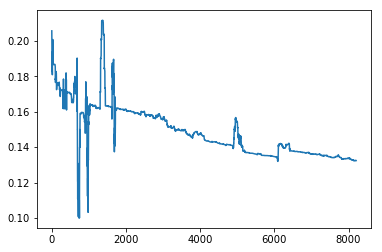

In [213]:
plt.plot(rolling_mean(losses, 100))

In [211]:
res = []
for i in range(100):
    res.append(forward_pass(mpnn, train_smiles[i], passes).data[0][0])

(array([ 75.,  10.,   4.,   5.,   2.,   0.,   0.,   0.,   0.,   4.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

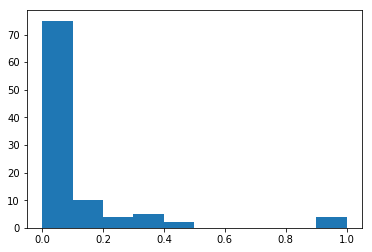

In [212]:
plt.hist(res)

In [17]:
def forward_pass(self, x, t):
    g, h = self.get_features_from_smiles(x)
    g2, h2 = self.get_features_from_smiles(x)
#     for k, v in h.items():
#         print(v.data.numpy())
    for k in range(0, t):
        self.single_message_pass(g, h, k)
#         print('*'*33)
#         print(h[0])
    y_pred = self.R(h, h2)
    return y_pred

In [76]:
g, h = mpnn.get_features_from_smiles(train_smiles[10])

In [ ]:
np.array(losses[-50:]).mean()

In [ ]:
np.array(train_labels[:100]).mean()

In [ ]:
for i in range(50):
    print(i, int(train_labels[i]), int(res[i]))

In [ ]:
r = (np.array(res) > 0.5).astype(int)

In [244]:
mpnn.fold.cached_nodes

defaultdict(dict, {'E': {(Variable containing:
                1  0  0  0  0  0
               [torch.FloatTensor of size 1x6],): [0:0]E, (Variable containing:
                1  0  0  0  0  0
               [torch.FloatTensor of size 1x6],): [0:1]E, (Variable containing:
                0  1  0  0  1  0
               [torch.FloatTensor of size 1x6],): [0:2]E, (Variable containing:
                1  0  0  0  1  0
               [torch.FloatTensor of size 1x6],): [0:3]E, (Variable containing:
                1  0  0  0  0  0
               [torch.FloatTensor of size 1x6],): [0:4]E, (Variable containing:
                1  0  0  0  0  0
               [torch.FloatTensor of size 1x6],): [0:5]E, (Variable containing:
                1  0  0  0  0  0
               [torch.FloatTensor of size 1x6],): [0:6]E, (Variable containing:
                0  1  0  0  1  0
               [torch.FloatTensor of size 1x6],): [0:7]E, (Variable containing:
                1  0  0  0  1  0
               [

In [215]:
a = []
a.append([1, 2])
a.append([5,5,5])
a

[[1, 2], [5, 5, 5]]

## 2. Undirected models

In [ ]:
for p in mpnn.params:
    print(p.requires_grad)

In [ ]:
mpnn.params[-2]

In [ ]:
for p in mpnn.params:
    print(p.data.size())